In [2]:
from modular import  model_builder
from modular.data_aug import thermal_train_strong_transform
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)



In [3]:
num_epochs = [100]
embedding_dims = [256]  # Example of testing different embedding dimensions
experiment_name = "Resnet18_Final_Train"

In [4]:
from pathlib import Path
from modular.data_setup import setup_fsl_train_test_dataloaders
data_path = Path("data/")
TRAIN_EPISODES=200
TEST_EPISDOES=200
N_WAY=3
K_SHOT=5
Q_QUERY=10

train_loader, test_loader, fsl_dataset, _ = setup_fsl_train_test_dataloaders(
    data_path=data_path,
    transform=thermal_train_strong_transform,
    train_episodes=TRAIN_EPISODES,
    test_episodes=TEST_EPISDOES,
    n_way=N_WAY,
    k_shot=K_SHOT,
    q_query=Q_QUERY,
)

Dataset class distribution: {0: 38, 1: 31, 2: 42, 3: 31, 4: 38, 5: 34, 6: 37, 7: 35, 8: 28, 9: 25, 10: 30}
Found 11 valid classes with at least 15 samples each
Automatically split classes:
  Training classes (7): Rotor-0, A&C&B10, A&B50, A&C30, Noload, A30, A10
  Testing classes (4): Fan, A&C&B30, A&C10, A50
Training class distribution: {0: 38, 1: 31, 4: 38, 5: 34, 6: 37, 9: 25, 10: 30}
Testing class distribution: {2: 42, 3: 31, 7: 35, 8: 28}
Using n_way=3 for training, n_way=3 for testing
Valid classes for sampling: 7
Classes with counts: [(0, 38), (1, 31), (4, 38), (5, 34), (6, 37), (9, 25), (10, 30)]
Valid classes for sampling: 4
Classes with counts: [(2, 42), (3, 31), (7, 35), (8, 28)]


In [6]:
from pathlib import Path
from modular.utils    import create_writer, load_checkpoint
from modular.engine   import train_prototype_network

experiment_number = 0
for embedding_dim in embedding_dims:
    for epochs in num_epochs:
        experiment_number += 1
        print(f"[INFO] Running Experiment {experiment_number}: emb={embedding_dim}, epochs={epochs}")
        
        # 1) Create model + optimizer + scheduler
        model = model_builder.Resnet18(embedding_dim=embedding_dim).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
        
        # 2) Check for existing checkpoint
        ckpt_name = f"ResNet18_RETRAINED_NWAY_3_epochs_100.pth"
        ckpt_path = Path(r"C:\Users\Wael\Code\FSL\models") / ckpt_name
        
        if ckpt_path.exists():
            start_epoch = load_checkpoint(ckpt_path, model, optimizer, scheduler)
            print(f"[INFO] Found checkpoint, resuming from epoch {start_epoch}")
        else:
            start_epoch = 0
        
        # 3) Create TensorBoard writer
        writer = create_writer(
            experiment_name=f"exp{experiment_number}",
            model_name=f"Resnet18_Retrained_emb{embedding_dim}",
            extra=f"{epochs}epochs"
        )
        
        # 4) Train (or resume)
        results = train_prototype_network(
            model=model,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            optimizer=optimizer,
            n_way=N_WAY,
            device=device,
            epochs=epochs,
            start_epoch=start_epoch,    # ← pass resume point
            writer=writer,
            model_name=f"Resnet18_RetrainedV2.pth",
            patience=15
        )
        
        print("-" * 50 + "\n")


[INFO] Running Experiment 1: emb=256, epochs=100
[INFO] Found checkpoint, resuming from epoch 57
[INFO] Created SummaryWriter, saving to: runs\2025-05-03\exp1\Resnet18_Retrained_emb256\100epochs...


Training Progress:   0%|          | 0/43 [00:00<?, ?it/s]

[INFO] Saving model to: C:\Users\Wael\Code\FSL\models\Resnet18_RetrainedV2.pth
[INFO] New best model (acc=0.8287) saved at epoch 58
[INFO] Saving model to: C:\Users\Wael\Code\FSL\models\Resnet18_RetrainedV2.pth
[INFO] New best model (acc=0.8335) saved at epoch 59

Epoch 61/100
Train Loss: 0.5936 | Train Acc: 0.8268 | Test Loss: 0.6921 | Test Acc: 0.8320
[INFO] Saving model to: C:\Users\Wael\Code\FSL\models\Resnet18_RetrainedV2.pth
[INFO] New best model (acc=0.8415) saved at epoch 62

Epoch 66/100
Train Loss: 0.6118 | Train Acc: 0.8070 | Test Loss: 0.6817 | Test Acc: 0.8342

Epoch 71/100
Train Loss: 0.5974 | Train Acc: 0.8198 | Test Loss: 0.6905 | Test Acc: 0.8305

Epoch 76/100
Train Loss: 0.5859 | Train Acc: 0.8322 | Test Loss: 0.6555 | Test Acc: 0.8455
[INFO] Saving model to: C:\Users\Wael\Code\FSL\models\Resnet18_RetrainedV2.pth
[INFO] New best model (acc=0.8455) saved at epoch 76

Epoch 81/100
Train Loss: 0.5913 | Train Acc: 0.8197 | Test Loss: 0.6547 | Test Acc: 0.8463
[INFO] Savin

Final Training Loss: 0.5849, Final Testing Loss: 0.6642
Final Training Accuracy: 0.8322, Final Testing Accuracy: 0.8390
Model appears to be generalizing well with minimal overfitting.
Best testing accuracy 0.8463 achieved at epoch 24


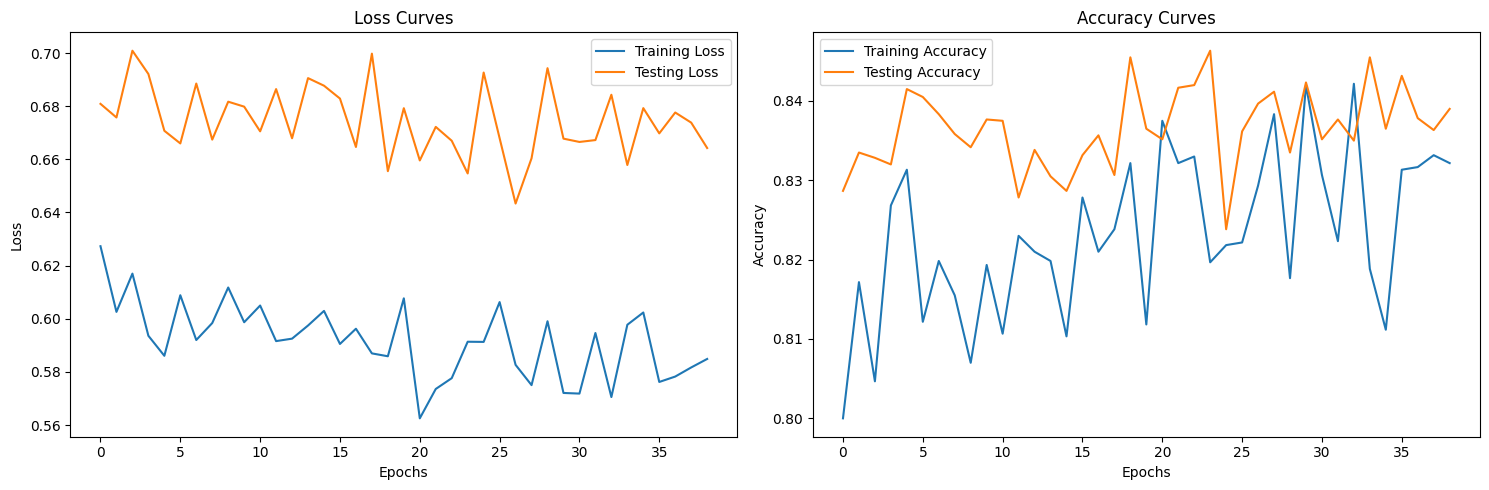

In [7]:
from modular.utils import analyze_model_performance,plot_training_results
analyze_model_performance(results)
plot_training_results(results)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs